# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 

# Pytorch
import torch 
from torch.utils.data import DataLoader

# Self-Defined Package
from SMAPDataset import SMAPDataset
from DNNTEST import DNNTEST
from SDLoss import physics_loss
from Preprocessing import random_spatial_sequence, collate_fn

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Training Loop

In [3]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = physics_loss 
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
#     ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
#     MultiStepLR = torch.optim.lr_scheduler.MultiStepLR(optimizer_MultiStepLR,
#                     milestones=[200, 300, 320, 340, 200], gamma=0.8)
#     CosineLR = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_CosineLR, T_max=150, eta_min=0)
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)
#     StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

    
    if not os.path.isdir(config['root'] + '\\OUTPUT\\MODELS\\'):
        os.mkdir(config['root'] + '\\OUTPUT\\MODELS\\') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        
        loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               # Set gradient to zero.
            pred = model(x)
#             x, pred = x.to(device), pred.to(device)   # Move your data to device. 
            
            loss = criterion(pred, data_pkg['label_data'], config['train_batch_size'])
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
        mean_train_loss = sum(loss_record)/len(loss_record)
#         print('Mean Loss for Epoch {}: {}'.format(epoch, mean_train_loss))

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
                print(pred)
#                 print(data_pkg['label_data'])
#             x, pred = x.to(device), pred.to(device)   # Move your data to device. 
                loss = criterion(pred, data_pkg['label_data'], config['valid_batch_size'])
            loss_record.append(loss.item())

        
        mean_valid_loss = sum(loss_record)/len(loss_record)
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}, LR: {current_lr}')

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'output'
            torch.save(model.state_dict(), config['root'] + '\\OUTPUT\\MODELS\\' + _name + '.ckpt') # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'output'
            torch.save(model.state_dict(), config['root'] + '\\OUTPUT\\MODELS\\' + _name + '.ckpt') # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 1234567890,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.            
    'train_batch_size': 100, 
    'valid_batch_size': 80,
    'test_batch_size': 1,
    'learning_rate': 5e-4,
    'step_size': 15,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 100,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [5]:
# # Set seed for reproducibility
same_seed(config['seed'])

##### 考虑到需要获取空间上均匀分布的站点数据，所以在每帧中随即挑选站点作为训练集，其余的作为验证集和测试集。因此使用一个字典来保存每天被筛选出来的站点list

In [6]:
train_sequence = {}
valid_sequence = {}
test_sequence = {}
s2s_dir = config['root'] + 'LABEL\\SMAPID2INSITUID'
subdir_list = sorted(os.listdir(s2s_dir))

# 遍历指定路径下的所有子目录
for subdir in subdir_list:
    subdir_path = os.path.join(s2s_dir, subdir)
    if os.path.isdir(subdir_path):
        # 如果子目录是目录而不是文件，则将子目录加入字典
        full_spatial_sequence_smap = sorted([int(f.split('.')[0]) for f in os.listdir(subdir_path) if f.endswith('.npy')]) # !!!! read out of order
        print(len(full_spatial_sequence_smap), 'of Full Spatial Sequence for', subdir, ':')
        print(full_spatial_sequence_smap)
        
        # Split the train\valid\test dataset by spatial dimension
        train_sequence[subdir], test_sequence[subdir] = random_spatial_sequence(1-config['test_ratio'], full_spatial_sequence_smap)
        train_sequence[subdir], valid_sequence[subdir] = random_spatial_sequence(1-config['valid_ratio'], train_sequence[subdir])

10 of Full Spatial Sequence for 2015104 :
[9, 15, 17, 18, 20, 26, 29, 31, 40, 43]
**************************Data Spliting***************************
Spliting Rate:  0.8
8 of Dataset1:  [43  9 40 26 15 18 20 31]
2 of Dataset2:  [17 29]
**************************Data Spliting***************************
**************************Data Spliting***************************
Spliting Rate:  0.9
7 of Dataset1:  [26 31 40 43 18 15  9]
1 of Dataset2:  [20]
**************************Data Spliting***************************
6 of Full Spatial Sequence for 2015106 :
[15, 16, 20, 26, 27, 29]
**************************Data Spliting***************************
Spliting Rate:  0.8
4 of Dataset1:  [26 20 16 15]
2 of Dataset2:  [27 29]
**************************Data Spliting***************************
**************************Data Spliting***************************
Spliting Rate:  0.9
3 of Dataset1:  [20 15 26]
1 of Dataset2:  [16]
**************************Data Spliting***************************
4 of Ful

In [7]:
# Initialize the dataset
train_dataset = SMAPDataset(config['root'], train_sequence)
valid_dataset = SMAPDataset(config['root'], valid_sequence)
test_dataset = SMAPDataset(config['root'], test_sequence)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, pin_memory=True, collate_fn=collate_fn)

***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 26_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015104\26.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\26.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015104\40.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015104\40.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015104\25.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015104\25.npy
_____________________________smap cell: 31_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015104\31.npy
D:\1GRADUATED\paper\downscaling_

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015226\37.npy
_____________________________smap cell: 18_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015226\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015226\31.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015226\31.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015226\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015226\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\A

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015330\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015330\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015330\42.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015330\42.npy
_____________________________smap cell: 18_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015330\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015330\31.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015330\31.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015211\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015211\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015211\11.npy
_______________________________2015213_______________________________
_____________________________smap cell: 9_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015213\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015213\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015213\55.npy
_____________________________smap cell: 29_____________________________
D:\1GRADUATED

In [8]:
print(train_dataset.__len__())
print(valid_dataset.__len__())
print(test_dataset.__len__())

251
56
102


# Data visualization

In [9]:
import matplotlib.pyplot as plt

In [10]:
def display_data_spatial_distribution(full_smapid_sequence, dict_sequence, data_name, root, seed):
    # 创建一个空数组
    bg_scale = -10
    z_scale = -5
    verified_mat = np.ones((7, 13))
    verified_mat = verified_mat * bg_scale
    verified_mat[0][2:7] = z_scale
    verified_mat[1][0:8] = z_scale
    verified_mat[2][0:10] = z_scale
    verified_mat[3][0:12] = z_scale
    verified_mat[4][2:13] = z_scale
    verified_mat[5][6:13] = z_scale
    verified_mat[6][7:12] = z_scale
    row_i = np.where(verified_mat!=bg_scale)[0]
    col_j = np.where(verified_mat!=bg_scale)[1]
    
    # 确定cell数据量的大小
    for smapid in full_smapid_sequence:
        y = [key for key, value in dict_sequence.items() if smapid in value]
        verified_mat[row_i[smapid]][col_j[smapid]] = len(y)

    plt.figure(figsize=(13, 7))
    plt.imshow(verified_mat, alpha=0.8, extent=[0, 13, 0, 7], vmin=-10, vmax=20, cmap='coolwarm')
    
    # 设置图形标题
    plt.title('Number of {} Data in Each Cell'.format(data_name))
    plt.xticks(range(14))
    plt.grid(True)
    plt.colorbar()
    
#     # 显示图形
#     plt.savefig(root + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\' + str(seed) + '\\' + data_name + 'DataSpatialDistribution.png', dpi=600, transparent=False)    
#     plt.show()


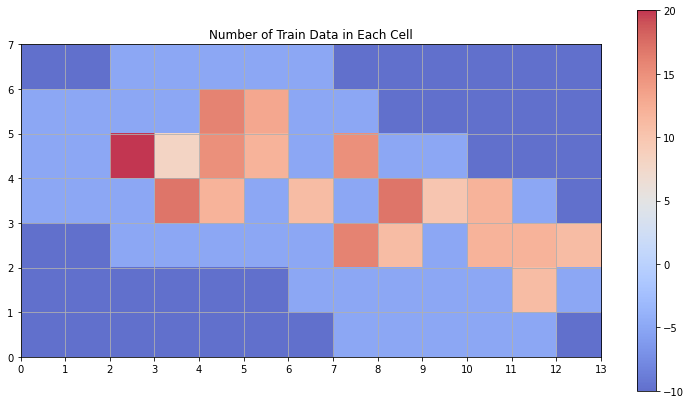

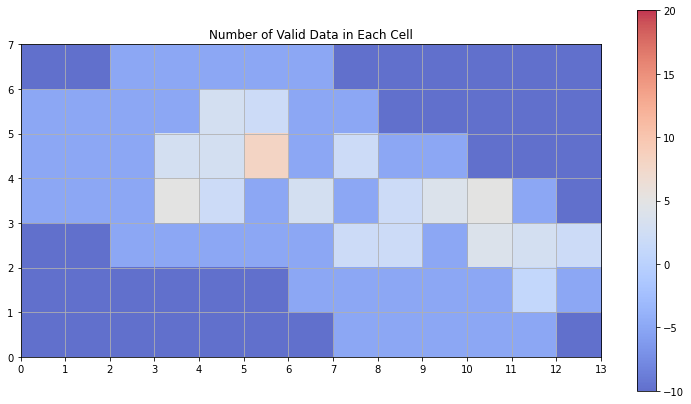

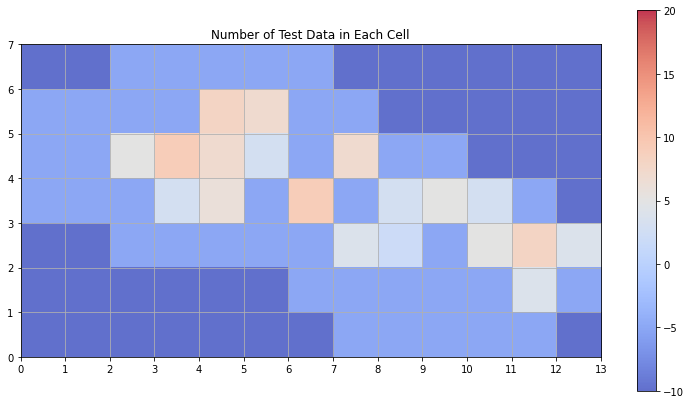

In [11]:
train_full_smapid_sequence = train_dataset.get_full_smapid_sequence()
valid_full_smapid_sequence = valid_dataset.get_full_smapid_sequence()
test_full_smapid_sequence = test_dataset.get_full_smapid_sequence()

display_data_spatial_distribution(train_full_smapid_sequence, train_sequence, 'Train', config['root'], config['seed'])
display_data_spatial_distribution(valid_full_smapid_sequence, valid_sequence, 'Valid', config['root'], config['seed'])
display_data_spatial_distribution(test_full_smapid_sequence, test_sequence, 'Test', config['root'], config['seed'])

In [12]:
def display_data_temporal_distribution(full_smapid_sequence, dict_sequence, data_name, root, seed):
    # 绘制散点图
    plt.figure(figsize=(13, 7))

    X = range(len(full_smapid_sequence))
    for i, smapid in enumerate(full_smapid_sequence):
        y = [int(key.split('2015')[1]) for key, value in dict_sequence.items() if smapid in value]
        x = [i] * len(y)  # 重复 X 坐标以便绘制多个散点
        plt.scatter(x, y)

    # 设置图形标题和坐标轴标签
    plt.title(data_name + ' Time Sequence Distribution for Each SMAP Cell')
    plt.xlabel("SMAPID")
    plt.ylabel("Day")
    plt.xticks(X, list(full_smapid_sequence))
    plt.yticks(np.arange(90, 360, 20))

#     # 显示图形
#     plt.savefig(root + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\' + str(seed) + '\\' + data_name + 'DataTemporalDistribution.png', dpi=600, transparent=False)    
#     plt.show()

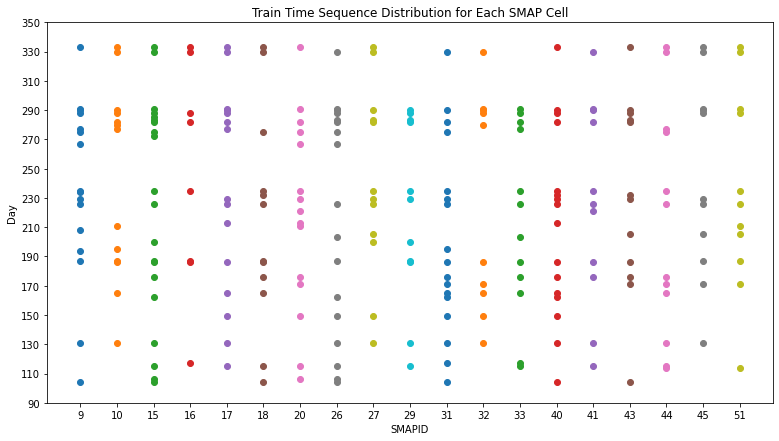

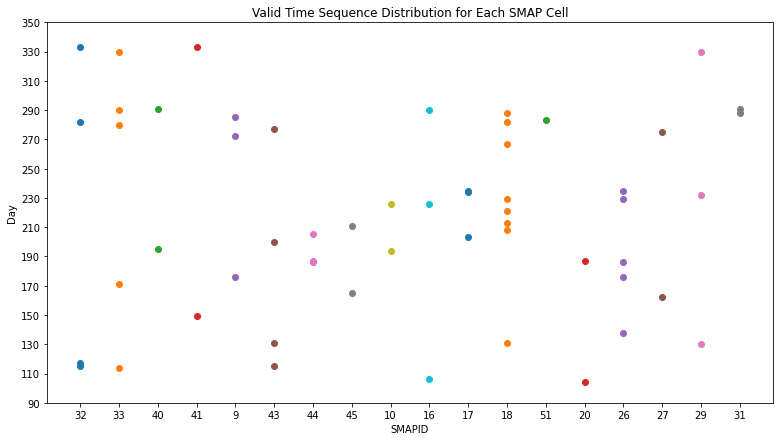

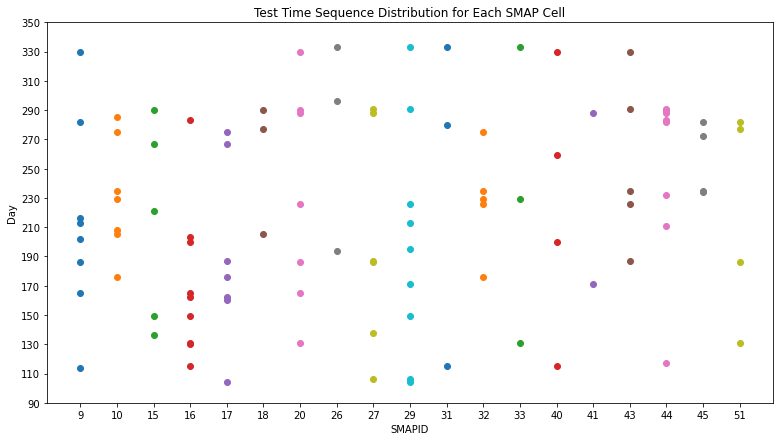

In [13]:
train_full_smapid_sequence = train_dataset.get_full_smapid_sequence()
valid_full_smapid_sequence = valid_dataset.get_full_smapid_sequence()
test_full_smapid_sequence = test_dataset.get_full_smapid_sequence()

display_data_temporal_distribution(train_full_smapid_sequence, train_sequence, 'Train', config['root'], config['seed'])
display_data_temporal_distribution(valid_full_smapid_sequence, valid_sequence, 'Valid', config['root'], config['seed'])
display_data_temporal_distribution(test_full_smapid_sequence, test_sequence, 'Test', config['root'], config['seed'])

In [14]:
# # 训练集sm站点数据
# sm = [x['label_data'][0][0] for x in train_dataset]
# x = [x for x in range(len(sm))]
# y = sm

# # 绘制散点图
# plt.scatter(x, y, c='red', s=10, alpha=1)

# # 添加标签和标题
# plt.ylim(0, 1)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('SM In-Situ')

# # 显示图像
# plt.show()

# # 训练集SMAP数据
# smap = [x['label_data'][0][1] for x in train_dataset]
# x = [x for x in range(len(sm))]
# y = smap

# # 绘制散点图
# plt.scatter(x, y, c='red', s=10, alpha=1)

# # 添加标签和标题
# plt.ylim(0, 1)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('SMAP')

# # 显示图像
# plt.show()


# # 创建数据
# ati = [x['label_data'][0][2] for x in train_dataset]
# # print(ati)
# x = [x for x in range(len(ati))]

# y1 = [x[0] for x in ati]
# y2 = [x[1] for x in ati]
# y3 = [x[2] for x in ati]

# # 创建子图
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# # 在第一个子图中绘制ATI
# ax1.scatter(x, y1)
# ax1.set_title('ATI')
# ax1.set_ylim([0,0.2])

# # 在第二个子图中绘制ATIM
# ax2.scatter(x, y2)
# ax2.set_title('ATIM')
# ax2.set_ylim([0,0.2])

# # 在第三个子图中绘制ATISD
# ax3.scatter(x, y3)
# ax3.set_title('ATISD')
# ax3.set_ylim([-0.002,0.02])

# # 显示图像
# plt.show()

In [15]:
# # 验证集sm站点数据
# sm = [x['label_data'][0][0] for x in valid_dataset]
# x = [x for x in range(len(sm))]
# y = sm

# # 绘制散点图
# plt.scatter(x, y, c='red', s=10, alpha=1)

# # 添加标签和标题
# plt.ylim(0, 1)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('SM In-Situ')

# # 显示图像
# plt.show()

# # 验证集SMAP数据
# smap = [x['label_data'][0][1] for x in valid_dataset]
# x = [x for x in range(len(sm))]
# y = smap

# # 绘制散点图
# plt.scatter(x, y, c='red', s=10, alpha=1)

# # 添加标签和标题
# plt.ylim(0, 1)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('SMAP')

# # 显示图像
# plt.show()


# # 创建数据
# ati = [x['label_data'][0][2] for x in valid_dataset]
# # print(ati)
# x = [x for x in range(len(ati))]

# y1 = [x[0] for x in ati]
# y2 = [x[1] for x in ati]
# y3 = [x[2] for x in ati]

# # 创建子图
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# # 在第一个子图中绘制sin函数
# ax1.scatter(x, y1)
# ax1.set_title('ATI')
# ax1.set_ylim([0,0.1])

# # 在第二个子图中绘制cos函数
# ax2.scatter(x, y2)
# ax2.set_title('ATIM')
# ax2.set_ylim([0,0.1])

# # 在第三个子图中绘制tan函数
# ax3.scatter(x, y3)
# ax3.set_title('ATISD')
# ax3.set_ylim([-0.01,0.05])

# # 显示图像
# plt.show()

# Start training!

In [16]:
if config['is_train']==True:
    model = DNNTEST(input_dim=train_dataset.get_input_shape(0)[0]).to(device) # put your model and data on the same computation device.
    print(train_dataset.get_input_shape(0)[0])
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

1937
DNNTEST(
  (layers): Sequential(
    (0): Linear(in_features=1937, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)
tensor([-0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398,
        -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398,
        -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1705, -0.1398,
        -0.1398, -0.1398, -0.1398, -0.1398, -0.1706, -0.1398, -0.1398, -0.1398,
        -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1441,
        -0.1398, -0.1398, -0.1398, -0.1398, -0.1741, -0.1398, -0.1398, -0.1398,
        -0.1398, -0.1398, -0.1398, -0.1398, -0.1398, -0.1440, -0.1398, -0.1697])
Epoch [1/3000]: Train loss: 4.6703, Valid loss: 0.2081, LR: 0.0005
Saving model with loss 0.208...
tensor([0.0772, 0.0772, 0.0772, 0.0772, 0.0772, 0.0772, 0.0772, 0.0772, 0.0772,
       

tensor([-0.0243, -0.0243, -0.0243, -0.0243, -0.0750, -0.0333, -0.0243, -0.0243,
        -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243,
        -0.0243, -0.0243, -0.0243, -0.0243, -0.0741, -0.0243, -0.0243, -0.0243,
        -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243,
        -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243,
        -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243, -0.0243,
        -0.0243, -0.0333, -0.0243, -0.0749, -0.0480, -0.0243, -0.0243, -0.0243])
Epoch [14/3000]: Train loss: 0.0606, Valid loss: 0.0297, LR: 0.0005
tensor([-0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075,
        -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075,
        -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075, -0.0075,
        -0.0075, -0.0075, -0.0177, -0.0075, -0.0609, -0.0075, -0.0177, -0.0311,
        -0.0075, -0.0075, -0.0075, -0.0075, -0.0075

tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0209, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0191, -0.0010,
        -0.0010, -0.0010, -0.0209, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0746, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0747, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0738, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010])
Epoch [27/3000]: Train loss: 0.0191, Valid loss: 0.0205, LR: 0.0005
tensor([-0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025,
        -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0195, -0.0223, -0.0025,
        -0.0025, -0.0766, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025,
        -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025, -0.0025,
        -0.0025, -0.0025, -0.0025, -0.0025, -0.0025

tensor([-0.0013, -0.0787, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0013, -0.0013, -0.0013, -0.0094, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0013, -0.0013, -0.0013, -0.0193, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0013, -0.0780, -0.0788, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0013, -0.0193, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013])
Epoch [40/3000]: Train loss: 0.0188, Valid loss: 0.0205, LR: 0.00025
tensor([-0.0011, -0.0777, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011,
        -0.0188, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011,
        -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011,
        -0.0011, -0.0084, -0.0011, -0.0011, -0.0011, -0.0011, -0.0011, -0.0187,
        -0.0011, -0.0011, -0.0011, -0.0785, -0.001

tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0173, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0797, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0796, -0.0010, -0.0010, -0.0010,
        -0.0173, -0.0010, -0.0010, -0.0010, -0.0029, -0.0010, -0.0010, -0.0788,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010])
Epoch [53/3000]: Train loss: 0.0188, Valid loss: 0.0204, LR: 0.000125
tensor([-0.0172, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0172, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0788, -0.00

tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0172, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0171, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0810, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0801,
        -0.0010, -0.0010, -0.0809, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010])
Epoch [66/3000]: Train loss: 0.0188, Valid loss: 0.0204, LR: 6.25e-05
tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0171, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0171, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0810, -0.0010, -0.0010, -0.00

tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0821, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0813, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0177, -0.0010, -0.0178, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0821, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010])
Epoch [79/3000]: Train loss: 0.0188, Valid loss: 0.0204, LR: 6.25e-05
tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0179, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0823, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0814, -0.0010, -0.0010, -0.00

tensor([-0.0010, -0.0010, -0.0827, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0181, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0182, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0828, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0819, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010])
Epoch [92/3000]: Train loss: 0.0188, Valid loss: 0.0204, LR: 3.125e-05
tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0182, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0828, -0.0182, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0

tensor([-0.0010, -0.0184, -0.0010, -0.0010, -0.0184, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0832, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0831, -0.0010, -0.0823, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010])
Epoch [105/3000]: Train loss: 0.0188, Valid loss: 0.0204, LR: 1.5625e-05
tensor([-0.0010, -0.0184, -0.0831, -0.0010, -0.0010, -0.0010, -0.0823, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0832, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0

tensor([-0.0010, -0.0010, -0.0185, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0833, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0834, -0.0010, -0.0825, -0.0010,
        -0.0010, -0.0010, -0.0010, -0.0010, -0.0185, -0.0010, -0.0010, -0.0010])
Epoch [118/3000]: Train loss: 0.0188, Valid loss: 0.0204, LR: 7.8125e-06

Model is not improving, so we halt the training session.


## Testing

In [17]:
def tester(test_loader, model, config, device):
    criterion = physics_loss # Define your loss function, do not modify this.
    model.eval() # Set your model to evaluation mode.
    loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
#         x, y = x.to(device), y.to(device)   # Move your data to device. 
        with torch.no_grad():
            pred = model(x)
            loss = criterion(pred, data_pkg['label_data'], config['test_batch_size'])
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    print(len(loss_record))
    print(mean_test_loss)
#     print(loss_record)  
    return loss_record

In [18]:
param_path = os.path.join(config['root'],'OUTPUT\\MODELS\\output.ckpt' )
model = DNNTEST(input_dim=train_dataset.get_input_shape(0)[0]).to(device)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 

102
0.029116138218992716


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

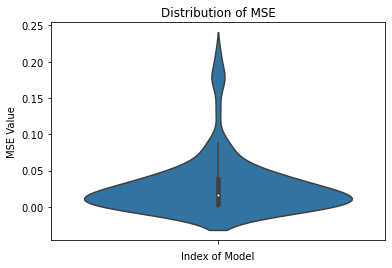

In [20]:
# 将数据转换为DataFrame格式
df = pd.DataFrame(loss_record, columns=['MSE'])

# 绘制小提琴图
sns.violinplot(y='MSE', data=df, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of MSE')
plt.xlabel('Index of Model')
plt.ylabel('MSE Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()